### STA analysis in Python

*What is an STA?* Simply, a spike-triggered average is the average of some variable taken around the spike times of a single neuron. There are lots of mathematical and conceptual details that we're not interested in right now. Crucially, this is an analysis that is fairly common in neuroscience, especially visual neuroscience (particularly for modeling receptive fields), so it's likely that you'll encounter it at some point if you haven't already. Here, I'll show you how to perform it in Python. 

*In the lab...*
After we were able to conclusively show that neurons exhibit sharp electrical impulses that we term "spikes," our next grant application was successful. However, it was a small grant, so all we were able to do was buy a flashlight. With this new equipment, we did the same experiment as before but this time we flashed our light on and off randomly while recording from one of these visually sensitive neurons. 

#### 1D STA

In [3]:
import numpy as np
import scipy.io as sio # try loading .mat file in way loaded previous file first

new_data = sio.loadmat('flashlight_data.mat')
print new_data

{'stimulus': array([[ 1.,  1., -1., ...,  1.,  1.,  1.]]), '__version__': '1.0', '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Mar  8 15:55:47 2016', 'spiketimes': array([[    60,     64,     93, ..., 999981, 999992, 999993]]), '__globals__': []}


In [40]:
# the new_data variable is a new type: dictionaries, they are similar to matlab's structure type
# so let's access these "fields"

# new_data.stimulus # in python, we reference the fields of dictionaries by [<fieldname>]
stim = flash_data['stimulus'].T[:, 0] # add .T after someone notices it, make point about len() or iteration
spks = flash_data['spiketimes'].T[:, 0]

# we read online somewhere that the stimulus for this sort of thing should have zero mean
print 'stimulus mean: {}'.format(np.mean(stim))
print 'stimulus shape: {}'.format(stim.shape)
print 'number of spikes: {}'.format(spks.shape)

stimulus mean: 0.001282
stimulus shape: (1000000,)
number of spikes: (57754,)


In [23]:
# close enough; looks like we've got quite a bit of data

# what's the firing rate of this neuron? (plot PSTH with function from previous part)
print 'firing rate: {}Hz'.format(1000*len(spks)/float(len(stim)))

# what else do we want to know? ISI distribution? Fano factor? CV? 

firing rate: 57.754Hz


In [41]:
# so how should we go about finding the spike-triggered average?

#what arguments should it take? What should it return? 
def get_sta(spks, stim, prespk=100, postspk=10):
    all_regions = np.zeros((len(spks), prespk + postspk))
    for i, s in enumerate(spks): # iterate directly through spks, through inds, or using enumerate?
        # for each spike, we want to pull out some region of stimulus around them? 
        # where should we specify the size of that region? default params
        if s >= prespk and s < len(stim) - postspk:
            stim_region = stim[s-prespk:s+postspk] # where should I put this?
            all_regions[i, :] = stim_region
        else:
            all_regions[i, :] = np.nan
    sta = np.nanmean(all_regions, axis=0) # axis of application
    return sta
    
# debug ValueError, put print statement for s...
# add if -- but what about the unused indices? replace with nan, use nanmean
# this extra dimension is just annoying, let's get rid of it! 
prespk = 100
postspk = 10

sta = get_sta(spks, stim, prespk=prespk, postspk=postspk)

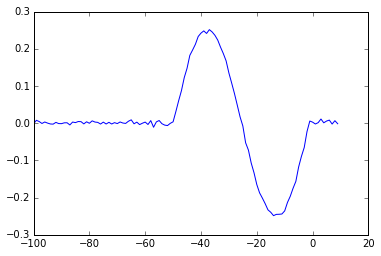

In [43]:
# well, this looks reasonable, but how can we get a better view?
import matplotlib.pyplot as plt
%matplotlib inline  

# what do we want to give to this function? 
def plot_sta(sta, prespk, postspk):
    ts = np.arange(-prespk, postspk, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.plot(ts, sta)
    plt.show()
    
plot_sta(sta, prespk, postspk)

In [ ]:
# do curve fitting -- wow! That looks like a sine wave!

#### 2D STA

Because we were able to compellingly show that neurons have a complex dependence on simple stimuli, we were able to get another grant. This time, we used the money to buy one hundred flashlights, which we tiled into a ten by ten grid -- then we used the rest of the money to hire undergraduates to turn the flashlights on and off in a random pattern. In this way, we can test the neuron's spatial and temporal dependence on the stimulus. 

In [86]:
mon_data = sio.loadmat('monitor_data_int.mat')
spks = mon_data['spiketimes'][0, :]
stim = mon_data['stimulus']

print stim.shape
print spks.shape

(1000000, 10, 10)
(57858,)


In [84]:

def get_2d_sta(spks, stim, prespk=70, postspk=10):
    all_regions = np.zeros((len(spks), prespk + postspk)+(stim.shape[-2:]))
    for i, s in enumerate(spks): # iterate directly through spks, through inds, or using enumerate?
        # for each spike, we want to pull out some region of stimulus around them? 
        # where should we specify the size of that region? default params
        if s >= prespk and s < len(stim) - postspk:
            stim_region = stim[s-prespk:s+postspk, :, :] # where should I put this?
            all_regions[i, :, :, :] = stim_region
        else:
            all_regions[i, :, :, :] = np.nan
    sta = np.nanmean(all_regions, axis=0) # axis of application
    return sta

stapre_2d = 70
stapost_2d = 20

sta_2d = get_2d_sta(spks, stim, prespk=stapre_2d, postspk=stapost_2d)

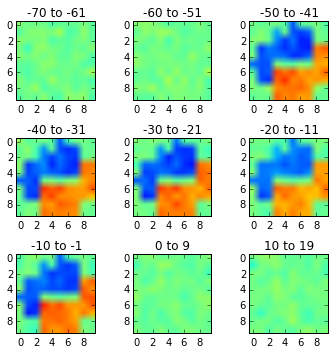

In [87]:
def plot_2d_sta(sta, stapre, stapost, n_ts=9., figsize=(5, 5)):
    f = plt.figure(figsize=figsize)
    slices_t = np.floor(sta.shape[0]/float(n_ts))
    n = np.ceil(np.sqrt(n_ts))
    allmin = np.min(sta)
    allmax = np.max(sta)
    ts = np.arange(-stapre, stapost)
    for i in xrange(int(n_ts)):
        sli = np.mean(sta[i*slices_t:(i+1)*slices_t], 0)
        ax = f.add_subplot(n, n, i+1)
        ax.imshow(sli, vmin=allmin, vmax=allmax)
        t0, t1 = ts[i*slices_t], ts[(i+1)*slices_t - 1]
        ax.set_title('{} to {}'.format(t0, t1))
    f.tight_layout()
    plt.show()

plot_2d_sta(sta_2d, stapre_2d, stapost_2d, n_ts=9.)